## 📚 Prerequisites

Before running this notebook, ensure you have configured Azure AI services, set the appropriate configuration parameters, and set up a Conda environment to ensure reproducibility. You can find the setup instructions and how to create a Conda environment in the [REQUIREMENTS.md](REQUIREMENTS.md) file.

## 📋 Table of Contents

This notebook guides you through the following sections:

1. [**Indexing Content from Multiple Sources (Cosmos DB and Blob Storage) Using SDK Push Option**](#index-multiple-sources)
    - This section covers how to chunk, vectorize, and index metadata extracted from documents sourced from Cosmos DB and Blob Storage.

    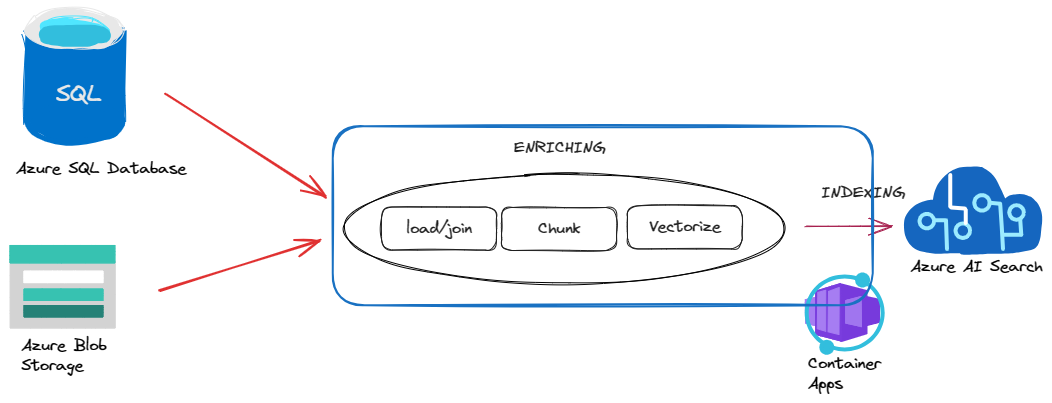

2. [**Indexing Content from Multiple Sources (Azure SQL DB and Blob Storage) Using Azure AI search Indexer Option**](#index-multiple-sources)
    - This section covers how to chunk, vectorize, and index metadata extracted from documents sourced from Azure SQL DB. It also explains how to synchronize data from Blob Storage to Azure SQL DB whenever a change is made in Blob Storage, considering Azure SQL DB as the source of truth.

    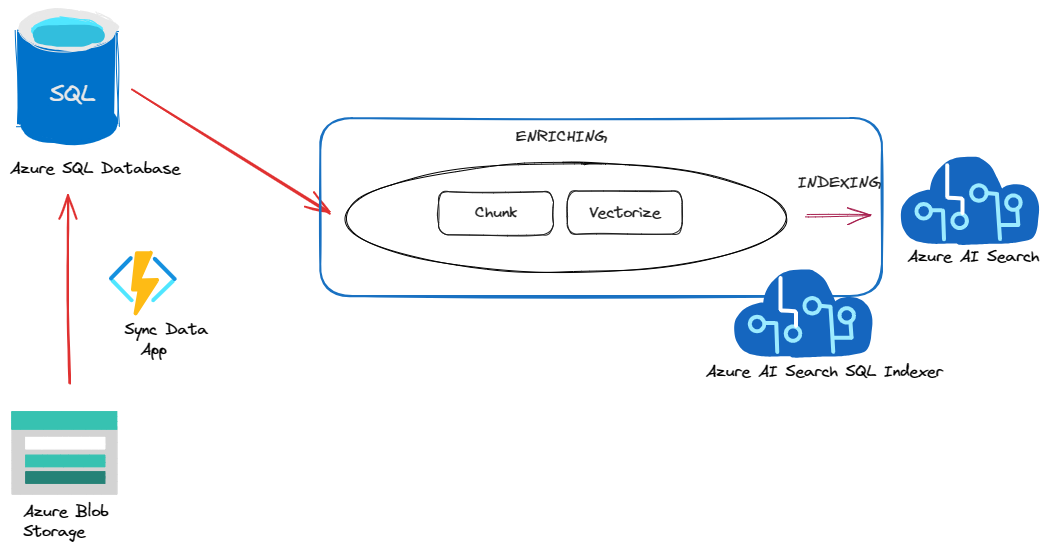

    > %pip install azure-search-documents==11.4.0

In [15]:
import os
from tenacity import retry, wait_random_exponential, stop_after_attempt
from dotenv import load_dotenv
import os
import json
import copy
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    ExhaustiveKnnAlgorithmConfiguration,
    ExhaustiveKnnParameters,
    SearchIndex,
    SearchField,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    SearchIndex,
    SemanticConfiguration,
    SemanticPrioritizedFields,
    SemanticField,
    SearchField,
    VectorSearch,
    SemanticSearch,
    HnswAlgorithmConfiguration,
    HnswParameters,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
    SearchIndex,
    SearchField,
    SearchFieldDataType,
    SimpleField,
    SearchableField,
    VectorSearch,
    ExhaustiveKnnParameters,
    SearchIndex,
    SearchField,
    SearchFieldDataType,
    ComplexField,
    SimpleField,
    SearchableField,
    SearchIndex,
    SemanticConfiguration,
    SemanticField,
    SearchField,
    VectorSearch,
    HnswParameters,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchAlgorithmMetric,
    VectorSearchProfile,
)

# Load environment variables from .env file
load_dotenv()

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-search-indexing"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-ai-search-indexing


## 📚 Indexing Content from Multiple Sources (Cosmos DB and Blob Storage) Using SDK Push Option

### Overview of Source Data 

The objective involves executing search operations within a composite data landscape, specifically focusing on employee performance evaluations and associated metadata. This multifaceted dataset comprises:

 + **Performance Reviews Stored in Cosmos DB**: These are detailed textual documents containing qualitative assessments of employee performance. They are persisted within Azure Cosmos DB, a globally distributed, multi-model database service. This allows for efficient retrieval and analysis of unstructured text data, leveraging Cosmos DB's robust querying capabilities and scalable storage solutions.

- **Employee Metadata in Blob Storage**: Complementary employee data, structured in CSV format, resides in Azure Blob Storage. This component of the dataset includes tabular data that encapsulates key employee attributes and metrics not covered in performance reviews. 

### Indexing Data In Cosmos DB

In [2]:
from src.indexers.cosmosIndexing import CosmosDBIndexer

cosmos_client = CosmosDBIndexer()
cosmos_client.create_database("gbbai-chat-with-your-employees-review")
unique_key_policy = {"uniqueKeys": [{"paths": ["/EmployeeId"]}]}

conflict_resolution_policy = {
    "mode": "lastWriterWins",
    "conflictResolutionPath": "/EmployeeId",
}

indexing_policy = {
    "indexingMode": "consistent",
    "automatic": True,
    "includedPaths": [
        {
            "path": "/*",
            "indexes": [
                {"kind": "Range", "dataType": "Number", "precision": -1},
                {"kind": "Range", "dataType": "String", "precision": -1},
            ],
        }
    ],
}

default_ttl = None
analytical_storage_ttl = None

cosmos_client.create_container(
    "gbbai-invoices",
    partition_key="/EmployeeId",
    throughput=None,
    unique_key_policy=unique_key_policy,
    conflict_resolution_policy=conflict_resolution_policy,
    indexing_policy=indexing_policy,
    default_ttl=default_ttl,
    analytical_storage_ttl=analytical_storage_ttl,
)

2024-04-01 13:46:05,528 - micro - MainProcess - INFO     Database 'gbbai-chat-with-your-employees-review' created successfully. (cosmosIndexing.py:create_database:59)
2024-04-01 13:46:05,613 - micro - MainProcess - INFO     Container 'gbbai-invoices' in database 'gbbai-chat-with-your-employees-review' created successfully. (cosmosIndexing.py:create_container:103)


In [3]:
review_data = [
    {
        "EmployeeId": "E02387",
        "name": "Emily Davis",
        "position": "Sr. Manager, IT, Research & Development",
        "date": "2024-04-01",
        "content": "Emily has consistently demonstrated exceptional leadership and technical expertise. Her ability to drive innovation and lead her team through complex projects has significantly contributed to the department's achievements. Under Emily's leadership, her team successfully launched three major projects that exceeded performance expectations, delivered on time and within budget. Emily's strengths lie in her strategic thinking, leadership, and technical acumen. She effectively manages resources and fosters a collaborative environment. Emily could enhance her impact by delegating more operational tasks to her team members, freeing up her time for strategic initiatives. Emily could benefit from executive leadership training and participating in conferences focusing on emerging technologies. Emily's goals should include leading her team to develop an innovative product prototype and working on enhancing cross-departmental collaboration.",
    },
    {
        "EmployeeId": "E04105",
        "name": "Theodore Dinh",
        "position": "Technical Architect, IT, Manufacturing",
        "date": "2024-04-01",
        "content": "Theodore has showcased remarkable expertise and dedication in his role as Technical Architect. His comprehensive knowledge and innovative approach to system architecture have been crucial in enhancing the efficiency and reliability of our manufacturing systems. Theodore's major accomplishment this period was the redesign of our manufacturing system's architecture, resulting in a 20% improvement in system efficiency and a significant reduction in downtime. His deep technical knowledge, innovative problem-solving skills, and ability to work under pressure are Theodore's most notable strengths. Expanding his collaboration with other departments could enhance project outcomes and innovation. Pursuing advanced certifications in emerging technologies relevant to manufacturing IT systems and attending global technology conferences could provide insights into industry trends. Theodore's goals for the next period should aim to lead a cross-functional project integrating IoT technologies into our manufacturing processes and mentoring junior team members.",
    },
]

In [4]:
cosmos_client.index_data(data_list=review_data, id_key="EmployeeId")

2024-04-01 13:46:05,671 - micro - MainProcess - INFO     Processing data item 1 of 2 (cosmosIndexing.py:index_data:123)
2024-04-01 13:46:05,672 - micro - MainProcess - INFO     Data before preprocessing: {'EmployeeId': 'E02387', 'name': 'Emily Davis', 'position': 'Sr. Manager, IT, Research & Development', 'date': '2024-04-01', 'content': "Emily has consistently demonstrated exceptional leadership and technical expertise. Her ability to drive innovation and lead her team through complex projects has significantly contributed to the department's achievements. Under Emily's leadership, her team successfully launched three major projects that exceeded performance expectations, delivered on time and within budget. Emily's strengths lie in her strategic thinking, leadership, and technical acumen. She effectively manages resources and fosters a collaborative environment. Emily could enhance her impact by delegating more operational tasks to her team members, freeing up her time for strategic 

[{'EmployeeId': 'E02387',
  'name': 'Emily Davis',
  'position': 'Sr. Manager, IT, Research & Development',
  'date': '2024-04-01',
  'content': "Emily has consistently demonstrated exceptional leadership and technical expertise. Her ability to drive innovation and lead her team through complex projects has significantly contributed to the department's achievements. Under Emily's leadership, her team successfully launched three major projects that exceeded performance expectations, delivered on time and within budget. Emily's strengths lie in her strategic thinking, leadership, and technical acumen. She effectively manages resources and fosters a collaborative environment. Emily could enhance her impact by delegating more operational tasks to her team members, freeing up her time for strategic initiatives. Emily could benefit from executive leadership training and participating in conferences focusing on emerging technologies. Emily's goals should include leading her team to develop an

### Retrieving Revies from Cosmos DB

In [5]:
query = "SELECT * FROM c WHERE c.date >= '2021-01-01'"

In [6]:
data = cosmos_client.execute_query(query)

2024-04-01 13:46:05,895 - micro - MainProcess - INFO     Query executed successfully. Retrieved 2 items. (cosmosIndexing.py:execute_query:196)


### Retrieving Structure Data from Blob Storage

In [7]:
from src.extractors.blob_data_extractors import AzureBlobDataExtractor

blob_extractor = AzureBlobDataExtractor()

In [8]:
df = blob_extractor.read_csv_from_blob(
    blob_name="Employee Sample Data.csv",
    container_name="testretrieval",
    sep=",",
    encoding="ISO-8859-1",
    header=0,
)
df.head()

,EEID,Full Name,Job Title,Department,Business Unit,Gender,Ethnicity,Age,Hire Date,Annual Salary,Bonus %,Country,City,Exit Date
0,E02387,Emily Davis,Sr. Manger,IT,Research & Development,Female,Black,55,4/8/2016,"$141,604",15%,United States,Seattle,10/16/2021
1,E04105,Theodore Dinh,Technical Architect,IT,Manufacturing,Male,Asian,59,11/29/1997,"$99,975",0%,China,Chongqing,NaN
2,E02572,Luna Sanders,Director,Finance,Speciality Products,Female,Caucasian,50,10/26/2006,"$163,099",20%,United States,Chicago,NaN
3,E02832,Penelope Jordan,Computer Systems Manager,IT,Manufacturing,Female,Caucasian,26,9/27/2019,"$84,913",7%,United States,Chicago,NaN
4,E01639,Austin Vo,Sr. Analyst,Finance,Manufacturing,Male,Asian,55,11/20/1995,"$95,409",0%,United States,Phoenix,NaN


### Creation of Index

In [9]:
# Set the service endpoint and API key from the environment
# Create an SDK client
endpoint = os.environ["AZURE_AI_SEARCH_SERVICE_ENDPOINT"]

admin_documents_index_client = SearchIndexClient(
    endpoint=endpoint,
    index_name=os.environ["AZURE_SEARCH_INDEX_NAME_EMPLOYEES"],
    credential=AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]),
)

In Azure Cognitive Search:

- `SimpleField` is used for fields that are filterable, sortable, or scorable but not full-text searchable. It's ideal for identifiers or timestamps.
- `SearchableField` is full-text searchable and can be used in filters, sorting, or scoring. It's suitable for text that you want to search within, like product descriptions or blog content.

Please refer to the notebook [01-creation-indexes.ipynb](01-creation-indexes.ipynb) for detailed information and steps on how to create Azure AI Search Indexes. 

In [10]:
combined_index_fields = [
    # The 'id' field now serves as the primary key for each record, unique across the entire index.
    SimpleField(name="id", type=SearchFieldDataType.String, key=True),
    # 'ParentId' holds the concatenation of the original document ID and the Cosmos DB ID, identifying the source document for each chunk.
    SimpleField(name="ParentId", type=SearchFieldDataType.String, filterable=True),
    # Searchable field for text analysis and queries, particularly the content of documents.
    SearchableField(name="content", type=SearchFieldDataType.String),
    # Vector field for semantic search capabilities on the document content.
    SearchField(
        name="content_vector",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        searchable=True,
        vector_search_dimensions=1536,
        vector_search_profile_name="myHnswProfile",
    ),
    # Metadata fields extracted from the structured CSV data.
    SearchableField(name="FullName", type=SearchFieldDataType.String),
    SimpleField(name="EmployeeId", type=SearchFieldDataType.String, filterable=True),
    SimpleField(name="Department", type=SearchFieldDataType.String, filterable=True),
    SimpleField(name="JobTitle", type=SearchFieldDataType.String, filterable=True),
    SimpleField(name="BusinessUnit", type=SearchFieldDataType.String, filterable=True),
    SimpleField(
        name="Gender", type=SearchFieldDataType.String, filterable=True, facetable=True
    ),
    SimpleField(
        name="Ethnicity",
        type=SearchFieldDataType.String,
        filterable=True,
        facetable=True,
    ),
    SimpleField(
        name="Age", type=SearchFieldDataType.Int32, filterable=True, sortable=True
    ),
    SimpleField(
        name="AnnualSalary",
        type=SearchFieldDataType.Double,
        filterable=True,
        sortable=True,
    ),
    SimpleField(
        name="BonusPercent",
        type=SearchFieldDataType.Double,
        filterable=True,
        sortable=True,
    ),
    SimpleField(
        name="Country", type=SearchFieldDataType.String, filterable=True, facetable=True
    ),
    SimpleField(
        name="City", type=SearchFieldDataType.String, filterable=True, facetable=True
    ),
]

In [11]:
# Configure the vector search configuration
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnsw",
            kind=VectorSearchAlgorithmKind.HNSW,
            parameters=HnswParameters(
                m=5,
                ef_construction=300,
                ef_search=400,
                metric=VectorSearchAlgorithmMetric.COSINE,
            ),
        ),
        ExhaustiveKnnAlgorithmConfiguration(
            name="myExhaustiveKnn",
            kind=VectorSearchAlgorithmKind.EXHAUSTIVE_KNN,
            parameters=ExhaustiveKnnParameters(
                metric=VectorSearchAlgorithmMetric.COSINE
            ),
        ),
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswProfile",
            algorithm_configuration_name="myHnsw",
        ),
        VectorSearchProfile(
            name="myExhaustiveKnnProfile",
            algorithm_configuration_name="myExhaustiveKnn",
        ),
    ],
)

In [12]:
semantic_config_combined_fields_index = SemanticConfiguration(
    name="combined-index-fields-semantic-config",
    prioritized_fields=SemanticPrioritizedFields(
        content_fields=[SemanticField(field_name="content")],
    ),
)
# Create the semantic settings with the configuration
semantic_search_audio_images = SemanticSearch(
    configurations=[semantic_config_combined_fields_index]
)

In [13]:
index = SearchIndex(
    name=os.environ["AZURE_SEARCH_INDEX_NAME_EMPLOYEES"],
    fields=combined_index_fields,
    vector_search=vector_search,
    semantic_search=semantic_search_audio_images,
)

try:
    result = admin_documents_index_client.create_or_update_index(index)
    print("Index", result.name, "created")
except Exception as ex:
    print(ex)

Index employees-index-dev created


### Integrating Multiple Data Sources for Azure AI Search Indexing

In this section, we are implementing a custom logic to merge data from multiple sources. The purpose of this operation is to create a comprehensive dataset that can be indexed effectively by Azure AI Search.

The process involves joining structured data (like CSV files) with unstructured data (like text files), and preparing this combined data for indexing. This includes converting data types, renaming columns, and generating necessary fields to match the schema of the Azure Search Index.

Once the data is prepared, it is converted into a list of dictionaries, which is the format required for indexing in Azure AI Search using the push API. This allows us to leverage the full-text search capabilities of Azure AI, enabling users to perform advanced search queries on the data.

In [2]:
import pandas as pd
from datetime import datetime

# Data preparation
cosmos_df = pd.DataFrame(data)
df.rename(
    columns={
        "EEID": "EmployeeId",
        "Annual Salary": "AnnualSalary",
        "Bonus %": "BonusPercent",
        "Hire Date": "HireDate",
        "Exit Date": "ExitDate",
    },
    inplace=True,
)
csv_file_name = "Employee_Sample_Data"
merged_df = pd.merge(cosmos_df, df, on="EmployeeId", how="left")

# Convert the necessary columns to the correct data types
merged_df["AnnualSalary"] = (
    merged_df["AnnualSalary"].str.replace("$", "").str.replace(",", "").astype(float)
)
merged_df["BonusPercent"] = (
    merged_df["BonusPercent"].str.replace("%", "").astype(float) / 100.0
)
# merged_df['HireDate'] = pd.to_datetime(merged_df['HireDate']).dt.strftime('%Y-%m-%dT%H:%M:%S')
# merged_df['ExitDate'] = pd.to_datetime(merged_df['ExitDate']).dt.strftime('%Y-%m-%dT%H:%M:%S')

# Generate 'ParentId'
merged_df["ParentId"] = merged_df["EmployeeId"] + "_" + csv_file_name

# Remove unnecessary Cosmos DB system keys and prepare fields for indexing
merged_df.drop(
    columns=[
        "_rid",
        "_self",
        "_etag",
        "_attachments",
        "_ts",
        "HireDate",
        "ExitDate",
        "name",
        "position",
        "date",
    ],
    inplace=True,
)

# Initialize 'id' and 'content_vector' for later population
merged_df["id"] = ""  # To be populated during vectorization and chunking
merged_df["content_vector"] = ""  # To be populated later

# Rename columns to match index field names
merged_df.rename(
    columns={
        "Full Name": "FullName",
        "Job Title": "JobTitle",
        "Business Unit": "BusinessUnit",
    },
    inplace=True,
)

# Convert the cleaned DataFrame back into a list of dictionaries for indexing
final_data_for_indexing = merged_df.to_dict(orient="records")

NameError: name 'data' is not defined

In [15]:
final_data_for_indexing

[{'EmployeeId': 'E02387',
  'content': "Emily has consistently demonstrated exceptional leadership and technical expertise. Her ability to drive innovation and lead her team through complex projects has significantly contributed to the department's achievements. Under Emily's leadership, her team successfully launched three major projects that exceeded performance expectations, delivered on time and within budget. Emily's strengths lie in her strategic thinking, leadership, and technical acumen. She effectively manages resources and fosters a collaborative environment. Emily could enhance her impact by delegating more operational tasks to her team members, freeing up her time for strategic initiatives. Emily could benefit from executive leadership training and participating in conferences focusing on emerging technologies. Emily's goals should include leading her team to develop an innovative product prototype and working on enhancing cross-departmental collaboration.",
  'id': '',
  '

### Chunk content, vectorize and Index 

In [16]:
search_client = SearchClient(
    endpoint=endpoint,
    index_name=os.environ["AZURE_SEARCH_INDEX_NAME_EMPLOYEES"],
    credential=AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]),
)

In [17]:
# Set the service endpoint and API key from the environment
# Create an SDK client
import openai
from openai import AzureOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter

openai.api_key = os.environ["AZURE_AOAI_API_KEY"]
openai.api_base = os.environ["AZURE_AOAI_API_ENDPOINT"]
openai.api_type = "azure"
openai.api_version = "2023-05-15"

model = os.environ["AZURE_AOAI_EMBEDDING_DEPLOYMENT_ID"]

client = AzureOpenAI(
    api_version=openai.api_version,
    azure_endpoint=openai.api_base,
    api_key=openai.api_key,
)

# This is in characters and there is an avg of 4 chars / token
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=150,
)

In [18]:
# Download and process files from a set of folders within a SharePoint site.

n = 100  # max batch size (number of docs) to upload at a time
total_docs_uploaded = 0

In [19]:
# Split up a list into chunks - this is used to ensure a limited number of items sent to Azure AI Search
def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i : i + n]


# Function to generate embeddings for content fields, also used for query embeddings
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def generate_embeddings(text):
    response = client.embeddings.create(input=text, model=model)
    return json.loads(response.model_dump_json())["data"][0]["embedding"]


chunked_content_docs = []
sfc_counter = 0
for sfc_counter in range(len(final_data_for_indexing)):
    chunked_content = text_splitter.split_text(
        final_data_for_indexing[sfc_counter]["content"]
    )
    chunk_counter = 0
    for cc in chunked_content:
        json_data = copy.deepcopy(final_data_for_indexing[sfc_counter])
        json_data["content"] = chunked_content[chunk_counter]
        json_data["content_vector"] = generate_embeddings(json_data["content"])
        json_data["ParentId"] = f"{json_data['ParentId']}"
        json_data["id"] = f"{json_data['ParentId']}_{chunk_counter}"
        chunk_counter += 1
        chunked_content_docs.append(json_data)
    sfc_counter += 1

total_docs = len(chunked_content_docs)
total_docs_uploaded += total_docs
print(f"Total Documents to Upload: {total_docs}")

for documents_chunk in divide_chunks(chunked_content_docs, n):
    try:
        print(f"Uploading batch of {len(documents_chunk)} documents...")
        result = search_client.upload_documents(documents=documents_chunk)
        # Check if all documents in the batch were uploaded successfully
        if all(res.succeeded for res in result):
            print(f"Upload of batch of {len(documents_chunk)} documents succeeded.")
        else:
            print("Some documents in the batch were not uploaded successfully.")
    except Exception as ex:
        print("Error in multiple documents upload: ", ex)

Total Documents to Upload: 6
Uploading batch of 6 documents...
Upload of batch of 6 documents succeeded.


### Retrieval Dat from Azure AI search

Before executing this notebook, please review the notebook `04-retrieval.ipynb` for a better understanding of the process. 

>%pip install azure-search-documents==11.4.0b10

In [1]:
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import RawVectorQuery

from src.aoai.azure_open_ai import AzureOpenAIManager

In [3]:
# Load environment variables from .env file
load_dotenv()

# Set up Azure Cognitive Search credentials
service_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")
key = os.getenv("AZURE_SEARCH_ADMIN_KEY")
credential = AzureKeyCredential(key)

# Define the name of the Azure Search index
# This is the index where your data is stored in Azure Search
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME_EMPLOYEES")

# Set up the Azure Search client with the specified index
# This prepares the client to interact with the Azure Search service
search_client = SearchClient(service_endpoint, index_name, credential=credential)

# Set up the Azure Search client with the specified index
# This prepares the client to interact with the Azure Search service
search_client = SearchClient(service_endpoint, index_name, credential=credential)

embedding_aoai_deployment_model = "foundational-canadaeast-ada"
aoai_client = AzureOpenAIManager(embedding_model_name=embedding_aoai_deployment_model)

search_query = "has showcased remarkable expertise and dedication"
search_vector = aoai_client.generate_embedding(search_query)

In [4]:
# hybrid retrieval + rerank
r = search_client.search(
    search_query,
    top=5,
    vector_queries=[
        RawVectorQuery(vector=search_vector, k=50, fields="content_vector")
    ],
    query_type="semantic",
    semantic_configuration_name="combined-index-fields-semantic-config",
    query_language="en-us",
)

for doc in r:
    content = doc["content"].replace("\n", " ")[:100]
    print(
        f"ID: {doc['id']}, Age: {doc['Age']}, Annual Salary: {doc['AnnualSalary']}, score: {doc['@search.score']}, reranker: {doc['@search.reranker_score']}. {content}"
    )

ID: E04105_Employee_Sample_Data_0, Age: 59, Annual Salary: 99975.0, score: 0.03333333507180214, reranker: 3.553462028503418. Theodore has showcased remarkable expertise and dedication in his role as Technical Architect. His c
ID: E02387_Employee_Sample_Data_0, Age: 55, Annual Salary: 141604.0, score: 0.032786883413791656, reranker: 1.8165210485458374. Emily has consistently demonstrated exceptional leadership and technical expertise. Her ability to d
ID: E02387_Employee_Sample_Data_1, Age: 55, Annual Salary: 141604.0, score: 0.03125763311982155, reranker: 1.536381721496582. on time and within budget. Emily's strengths lie in her strategic thinking, leadership, and technica
ID: E02387_Employee_Sample_Data_2, Age: 55, Annual Salary: 141604.0, score: 0.0314980149269104, reranker: 1.4992340803146362. executive leadership training and participating in conferences focusing on emerging technologies. Em
ID: E04105_Employee_Sample_Data_1, Age: 59, Annual Salary: 99975.0, score: 0.03225806355476

### Example 1 - Filtering Data Based on Age and Annual Salary


expression `Age gt 58 and AnnualSalary lt 100000` 

The expression uses the 'gt' (greater than) and 'lt' (less than) operators to filter documents based on the values of the 'Age' and 'AnnualSalary' fields.

"Age gt 58" returns documents where the 'Age' field is greater than 58.
"AnnualSalary lt 100000" returns documents where the 'AnnualSalary' field is less than 100000.

The 'and' operator is used to combine these two conditions, so the expression only returns documents where both conditions are true. That is, it returns documents where the 'Age' field is greater than 58 and the 'AnnualSalary' field is less than 100000.


In [5]:
r = search_client.search(
    search_query,
    top=5,
    vector_queries=[
        RawVectorQuery(vector=search_vector, k=50, fields="content_vector")
    ],
    query_type="semantic",
    semantic_configuration_name="combined-index-fields-semantic-config",
    query_language="en-us",
    filter="Age gt 58 and AnnualSalary lt 100000",  # Add filter expression
)

for doc in r:
    content = doc["content"].replace("\n", " ")[:1000000]
    print(
        f"ID: {doc['id']}, Age: {doc['Age']}, Annual Salary: {doc['AnnualSalary']}, score: {doc['@search.score']}, reranker: {doc['@search.reranker_score']}. {content}"
    )

ID: E04105_Employee_Sample_Data_0, Age: 59, Annual Salary: 99975.0, score: 0.03333333507180214, reranker: 3.553462028503418. Theodore has showcased remarkable expertise and dedication in his role as Technical Architect. His c
ID: E04105_Employee_Sample_Data_1, Age: 59, Annual Salary: 99975.0, score: 0.032786883413791656, reranker: 1.4954043626785278. architecture, resulting in a 20% improvement in system efficiency and a significant reduction in dow
ID: E04105_Employee_Sample_Data_2, Age: 59, Annual Salary: 99975.0, score: 0.032258063554763794, reranker: 1.4904258251190186. advanced certifications in emerging technologies relevant to manufacturing IT systems and attending 


## Indexing Content from Multiple Sources (Azure SQL DB and Blob Storage) Using Azure AI search Indexer Option

In [1]:
from src.indexers.sql_Indexing import AzureSQLManager

DATABASE = "dev-sql-server"
az_sql_client = AzureSQLManager(DATABASE)

In [2]:
table_name = "foodreview"

# Drop previous table of same name if one exists
az_sql_client.execute(f"DROP TABLE IF EXISTS {table_name};")
print(
    f"Finished dropping table '{table_name}' if it existed. This ensures we are starting with a clean slate."
)

# Create a table
az_sql_client.execute(
    f"""
               CREATE TABLE {table_name} 
               (Id int NOT NULL, 
               CONSTRAINT PK_{table_name}_Id PRIMARY KEY CLUSTERED (Id), 
               ProductId text, 
               UserId text, 
               ProfileName text, 
               HelpfulnessNumerator integer, 
               HelpfulnessDenominator integer, 
               Score integer, 
               Time bigint, 
               Summary text, 
               Recommnedation NVARCHAR(MAX));
               """
)
print(
    f"Finished creating table '{table_name}'. This table will store our food review data."
)

# Create an index
az_sql_client.execute(f"CREATE INDEX idx_Id ON {table_name}(Id);")
print(
    f"Finished creating index 'idx_Id' on table '{table_name}'. This index will improve the performance of queries that filter by the 'Id' field."
)

Finished dropping table 'foodreview' if it existed. This ensures we are starting with a clean slate.
Finished creating table 'foodreview'. This table will store our food review data.
Finished creating index 'idx_Id' on table 'foodreview'. This index will improve the performance of queries that filter by the 'Id' field.


### Enable change tracking

This allows us to automatically update the index when changes are made to the data.

In [3]:
try:
    # Commit any active transactions
    az_sql_client.cursor.commit()

    # Enable change tracking at the database level
    az_sql_client.execute(
        f"ALTER DATABASE [{DATABASE}] SET CHANGE_TRACKING = ON (CHANGE_RETENTION = 2 DAYS, AUTO_CLEANUP = ON)"
    )
except Exception as e:
    print(e)

ERROR:root:Error executing query: ALTER DATABASE [dev-sql-server] SET CHANGE_TRACKING = ON (CHANGE_RETENTION = 2 DAYS, AUTO_CLEANUP = ON)
Error Message: ('42000', "[42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Change tracking is already enabled for database 'dev-sql-server'. (5088) (SQLExecDirectW); [42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]ALTER DATABASE statement failed. (5069)")
Traceback: Traceback (most recent call last):
  File "c:\Users\pablosal\Desktop\gbbai-azure-ai-search-indexing\src\indexers\sql_Indexing.py", line 78, in execute
    self.cursor.execute(query)
pyodbc.ProgrammingError: ('42000', "[42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Change tracking is already enabled for database 'dev-sql-server'. (5088) (SQLExecDirectW); [42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]ALTER DATABASE statement failed. (5069)")



('42000', "[42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Change tracking is already enabled for database 'dev-sql-server'. (5088) (SQLExecDirectW); [42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]ALTER DATABASE statement failed. (5069)")


In [4]:
try:
    # Enable change tracking on a specific table.
    # This is necessary to keep track of changes made to this specific table.
    # The TRACK_COLUMNS_UPDATED option is turned on, allowing the system to keep track of which columns were updated.
    az_sql_client.execute(
        f"ALTER TABLE {table_name} ENABLE CHANGE_TRACKING WITH (TRACK_COLUMNS_UPDATED = ON)"
    )
except Exception as e:
    print(e)

In [5]:
import numpy as np
import pandas as pd

try:
    all_reviews = pd.read_csv("utils/data/Reviews_small.csv")
    sample_reviews = all_reviews[:1000].copy()
    product_text_reviews = sample_reviews[["ProductId", "Text"]].copy()
    sample_reviews.drop(columns=["Text"], inplace=True)
    product_text_reviews.to_csv("utils/data/Reviews_text.csv", index=False)
except FileNotFoundError:
    print("File not found.")
except Exception as e:
    print(f"Error: {e}")

### Uploading Data to SQL Server

In [6]:
batch_size = 30
batches = [
    sample_reviews[i : i + batch_size]
    for i in range(0, len(sample_reviews), batch_size)
]

# Iterate over each batch and insert or update the data in the database
for batch in batches:
    # Convert the batch dataframe to a list of tuples for bulk insertion
    rows = [tuple(row) for row in batch.itertuples(index=False)]

    # Define the SQL query for bulk insertion or update
    query = f"""
    MERGE INTO {table_name} AS Target
    USING (VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)) AS Source (Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary)
    ON CAST(Target.ProductId AS NVARCHAR(MAX)) = Source.ProductId
    WHEN MATCHED THEN 
        UPDATE SET UserId = Source.UserId, ProfileName = Source.ProfileName, HelpfulnessNumerator = Source.HelpfulnessNumerator, HelpfulnessDenominator = Source.HelpfulnessDenominator, Score = Source.Score, Time = Source.Time, Summary = Source.Summary
    WHEN NOT MATCHED THEN
        INSERT (Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary)
        VALUES (Source.Id, Source.ProductId, Source.UserId, Source.ProfileName, Source.HelpfulnessNumerator, Source.HelpfulnessDenominator, Source.Score, Source.Time, Source.Summary);
    """
    az_sql_client.cursor.executemany(query, rows)

In [7]:
# Execute the SELECT statement
try:
    data = az_sql_client.execute_and_fetch(f"SELECT count(Id) FROM {table_name};")
    print(data)
except Exception as e:
    print(f"Error executing SELECT statement: {e}")

[(29,)]


In [9]:
data = az_sql_client.execute_and_fetch(f"SELECT * FROM {table_name};")
data[:5]

[(1, 'B001E4KFG0', 'A3SGXH7AUHU8GW', 'delmartian', 1, 1, 5, 1303862400, 'Good Quality Dog Food', None),
 (2, 'B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', 0, 0, 1, 1346976000, 'Not as Advertised', None),
 (3, 'B000LQOCH0', 'ABXLMWJIXXAIN', 'Natalia Corres "Natalia Corres"', 1, 1, 4, 1219017600, '"Delight" says it all', None),
 (4, 'B000UA0QIQ', 'A395BORC6FGVXV', 'Karl', 3, 3, 2, 1307923200, 'Cough Medicine', None),
 (5, 'B006K2ZZ7K', 'A3JRGQVEQN31IQ', 'Pamela G. Williams', 0, 0, 5, 1336003200, 'Wonderful, tasty taffy', None)]

### Indexing Data from Blob Storage

In [10]:
from src.extractors.blob_data_extractors import AzureBlobDataExtractor

blob_client = AzureBlobDataExtractor()

In [11]:
df_from_blob = blob_client.read_csv_from_blob(
    "Reviews_text.csv", "testretrieval", sep=",", encoding="ISO-8859-1", header=0
)
df_from_blob["ProductId"] = df_from_blob["ProductId"].astype(str)
df_from_blob["Recommnedation"] = df_from_blob["Text"].astype(str)

In [12]:
batch_size = 30
batches = [
    df_from_blob[i : i + batch_size] for i in range(0, len(df_from_blob), batch_size)
]

for batch in batches:
    # Convert the batch dataframe to a list of tuples for bulk update
    # Adjust the unpacking to match the actual structure of your DataFrame tuples
    rows = [(text, product_id) for _, product_id, text, *_ in batch.itertuples()]

    # Define the SQL query for bulk update
    query = f"UPDATE {table_name} SET Recommnedation = ? WHERE CAST(ProductId AS NVARCHAR(MAX)) = ?"
    az_sql_client.cursor.executemany(query, rows)

In [14]:
data = az_sql_client.execute_and_fetch(f"SELECT * FROM {table_name};")
data[:5]

[(1, 'B001E4KFG0', 'A3SGXH7AUHU8GW', 'delmartian', 1, 1, 5, 1303862400, 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'),
 (2, 'B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', 0, 0, 1, 1346976000, 'Not as Advertised', 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'),
 (3, 'B000LQOCH0', 'ABXLMWJIXXAIN', 'Natalia Corres "Natalia Corres"', 1, 1, 4, 1219017600, '"Delight" says it all', 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mou